## 목차

1. Best-first search
2. Breadth-first search
3. Uniform-cost search
4. Depth-first search
5. Depth limited and Iterative deepening search
6. Greedy best-first search
7. A* search
8. Weighted A* search

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations

# 1. Problem, Node, PriorityQueue Class

In [ ]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwargs):
      """The constructor specifies the initial state, and possibly a goal
      state, if there is a unique goal. Your subclass's constructor can add
      other arguments."""
      self.__dict__.update(initial=initial, goal=goal, **kwargs)

    def actions(self, state):
      raise NotImplementedError

    def result(self, state, action):
      raise NotImplementedError

    def is_goal(self, state):
      return state == self.goal

    def action_cost(self, s, a, s1):
      return 1

    def h(self, node):
      return 0

    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

*   `__init__(self, initial, goal)` : 생성자(constructor)라고 불리며, 클래스의 객체(instance)를 생성할 때 처음 호출되는 메소드이다. 예를 들어 `Problem(initial, goal)`로 클래스의 객체를 만들 때 사용된다. 변수 initial은 탐색 문제의 초기 상태를 지정하며, start state을 나타낸다.

*   `actions(self, state)` : 주어진 상태에서 에이전트가 실행할 수 있는 모든 가능한 동작(액션)을 반환한다.

*   `result(self, state, action)` :  주어진 상태에서 주어진 동작을 실행했을 때의 결과 상태를 반환한다.

*   `is_goal(self, state)` : 주어진 상태가 goal state인지 여부를 판단하여 Boolean 값을 반환한다. Goal state인 경우 True를 반환하고, 그렇지 않은 경우 False를 반환한다.

*   `action_cost(self, s, a, s1)` : State `s`에서 action `a`를 취하여 state `s1`로 도달하는 경로의 비용을 반환한다.

*    `h(self, node)` : 주어진 노드에 대한 휴리스틱 값을 반환한다.

*   `__str__(self)` : 표준 파이썬 기능을 오버라이드하여 해당 클래스의 객체를 문자열로 표현한다.



In [ ]:
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    def __repr__(self):
      return '<{}>'.format(self.state)

    def __len__(self):
      return 0 if self.parent is None else (1 + len(self.parent))

    def __lt__(self, other):
      return self.path_cost < other.path_cost

*   `__init__(self, state, parent, action, path_cost)` : `Node` 클래스의 객체를 생성하는 생성자이다. `parent`는 현재 노드의 이전 노드를 나타내며, `action`은 부모 노드에서 현재 노드로 이동하는 데 필요한 행동이다. `path_cost`는 부모 노드로부터 현재 노드에 도달하는 비용이다.

*   `__repr__(self)` : 노드를 나타내는 문자열을 반환한다.

*   `__len__(self, other)` : 노드에서 부모 노드까지의 경로의 길이를 반환한다.

*   `__lt__(self, node)` : 현재 노드의 경로 비용이 다른 노드의 경로 비용보다 작은지 여부를 판단한다.

In [ ]:
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []
    return path_actions(node.parent) + [node.action]

def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None):
        return []
    return path_states(node.parent) + [node.state]

In [ ]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x):
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)

    def add(self, item):
        """Add item to the queue."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]

    def top(self):
      return self.items[0][1]

    def __len__(self):
      return len(self.items)

# 2. RouteProblem

<img src='https://wikidocs.net/images/page/189097/Fig_03_01.PNG' width=700px>

In [ ]:
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [ ]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""

    def __init__(self, initial=None, goal=None, **kwargs):
      super().__init__(initial=initial, goal=goal, **kwargs)

    def actions(self, state):
        """The places neighboring `state`."""
        return self.map.neighbors[state]

    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state

    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]

    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])

In [ ]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them.
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs,
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)}
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = self.multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))


    def multimap(self, pairs) -> dict:
        "Given (key, val) pairs, make a dict of {key: [val,...]}."
        result = defaultdict(list)
        for key, val in pairs:
            result[key].append(val)
        return result

In [ ]:
romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118,
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146,
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101,
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142,
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294),
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)

In [ ]:
route = r1 # Arad to Bucharest

# 3. Uninformed Search Algorithms

## Best-first search

In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

In [ ]:
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)

## Breadth-first search

In [ ]:
# TODO 1
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure

In [ ]:
# TODO 2
solution = breadth_first_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'F', 'B']
path cost: 450.0


## Uniform-cost search

In [ ]:
# TODO 3
def g(n): return n.path_cost

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)


In [ ]:
# TODO 4
solution = uniform_cost_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'R', 'P', 'B']
path cost: 418.0


## Depth-first search

In [ ]:
# TODO 5
def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))


In [ ]:
# TODO 6
solution = depth_first_bfs(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B']
path cost: 733.0


## Depth-limited and Iterative deepening search

In [ ]:
def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)

In [ ]:
# TODO 7
def depth_limited_search(problem, limit=10):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result


*   *depth*: `sys.maxsize`

In [ ]:
# TODO 8
def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result


In [ ]:
# TODO 9
solution = depth_limited_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B']
path cost: 733.0


In [ ]:
# TODO 10
solution = iterative_deepening_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'F', 'B']
path cost: 450.0


# 4. Informed search algorithms

## Greedy best-first search

In [ ]:
# TODO 11
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


In [ ]:
# TODO 12
solution = greedy_bfs(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'F', 'B']
path cost: 450.0


## A* search

In [ ]:
# TODO 13
def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))

In [ ]:
# TODO 14
solution = astar_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'R', 'P', 'B']
path cost: 418.0


## Weighted A* search

In [ ]:
# TODO 15
def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))


In [ ]:
# TODO 16
solution = weighted_astar_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'F', 'B']
path cost: 450.0


# 5. Reporting Summary Statistics on Search Algorithms

In [ ]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()

    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)


def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts;
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')

def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))

*   Search algorithms: `breadth_first_search, uniform_cost_search, depth_first_bfs, iterative_deepening_search, depth_limited_search, greedy_bfs, astar_search, weighted_astar_search`
*   RouteProblems: `r1, r2, r3, r4`

In [ ]:
# TODO 17
report([breadth_first_search, uniform_cost_search, depth_first_bfs,
        iterative_deepening_search, depth_limited_search, greedy_bfs, astar_search,
        weighted_astar_search], [r1, r2, r3, r4])

breadth_first_search:
       18 nodes |       19 goal |  450 cost |      10 actions | RouteProblem('A', 'B')
       42 nodes |       43 goal | 1085 cost |      27 actions | RouteProblem('N', 'L')
       36 nodes |       37 goal |  837 cost |      22 actions | RouteProblem('E', 'T')
       30 nodes |       31 goal |  445 cost |      16 actions | RouteProblem('O', 'M')
      126 nodes |      130 goal | 2817 cost |      75 actions | TOTAL

uniform_cost_search:
       30 nodes |       13 goal |  418 cost |      16 actions | RouteProblem('A', 'B')
       42 nodes |       19 goal |  910 cost |      27 actions | RouteProblem('N', 'L')
       44 nodes |       20 goal |  805 cost |      27 actions | RouteProblem('E', 'T')
       30 nodes |       12 goal |  445 cost |      16 actions | RouteProblem('O', 'M')
      146 nodes |       64 goal | 2578 cost |      86 actions | TOTAL

depth_first_bfs:
       21 nodes |       10 goal |  733 cost |      16 actions | RouteProblem('A', 'B')
       30 nodes

# 6. GridProblem: Comparing reached states

In [ ]:
class GridProblem(Problem):
    """Finding a path on sa 2D grid with obtacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwargs):
        Problem.__init__(self, initial=initial, goal=goal,
                         obstacles=set(obstacles) - {initial, goal}, **kwargs)

        self.directions = [(-1, -1), (0, -1), (1, -1),
                           (-1, 0),           (1,  0),
                           (-1, +1), (0, +1), (1, +1)]

    def action_cost(self, s, action, s1):
      return straight_line_distance(s, s1)

    def h(self, node):
      return straight_line_distance(node.state, self.goal)

    def result(self, state, action):
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state

    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles

In [ ]:
def random_lines(X=range(15, 130), Y=range(60), N=150, lengths=range(6, 12)):
    """The set of cells in N random lines of the given lengths."""
    result = set()
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(((0, 1), (1, 0)))
        result |= line(x, y, dx, dy, random.choice(lengths))
    return result

def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

In [ ]:
def plot_grid_problem(grid, solution, reached, title='Search'):
    """
    Use matplotlib to plot the grid, obstacles, solution, and reached.
    """
    plt.figure(figsize=(16, 10))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose([grid.initial]), 9**2, marker='D', c='green')
    plt.scatter(*transpose([grid.goal]), 9**2, marker='8', c='red')
    if solution != None:
      plt.scatter(*transpose(path_states(solution)), marker='s', c='blue')
      print('{} search: {:.1f} path cost'.format(title, solution.path_cost))
    if reached != None:
      reached = list(reached)
      plt.scatter(*transpose(reached), 1**2, marker='.', c='blue')
      print('{:,d} states reached'.format(len(reached)))
    plt.show()

def transpose(matrix): return list(zip(*matrix))

In [ ]:
random.seed(42) # To make this reproducible

frame = line(-10, 20, 0, 1, 20) | line(150, 20, 0, 1, 20)
cup = line(102, 44, -1, 0, 15) | line(102, 20, -1, 0, 20) | line(102, 44, 0, -1, 24)

d1 = GridProblem(obstacles=random_lines(N=100) | frame)
d2 = GridProblem(obstacles=random_lines(N=150) | frame)
d3 = GridProblem(obstacles=random_lines(N=200) | frame)
d4 = GridProblem(obstacles=random_lines(N=250) | frame)
d5 = GridProblem(obstacles=random_lines(N=300) | frame)
d6 = GridProblem(obstacles=cup | frame)
d7 = GridProblem(obstacles=cup | frame | line(50, 35, 0, -1, 10) | line(60, 37, 0, -1, 17) | line(70, 31, 0, -1, 19))

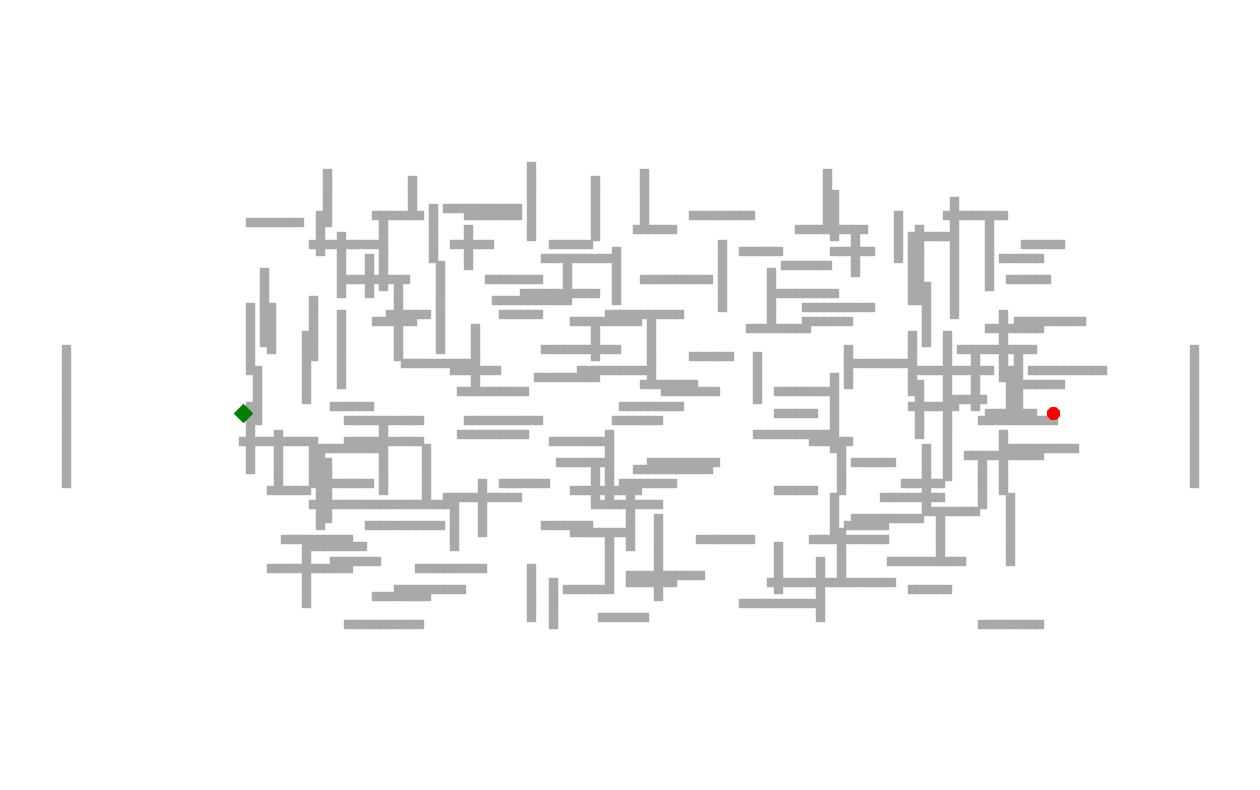

In [ ]:
plot_grid_problem(d3, solution=None, reached=None)

In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    global reached
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

위의 `best_first_search` 함수에서 `reached` 변수 `global`로 변경 후 아래 알고리즘의 결과 시각화:

*   `uniform_cost_search`
*   `greedy_bfs`
*   `astar_search`
*   `weighted_astar_search`

Uniform cost search search: 154.2 path cost


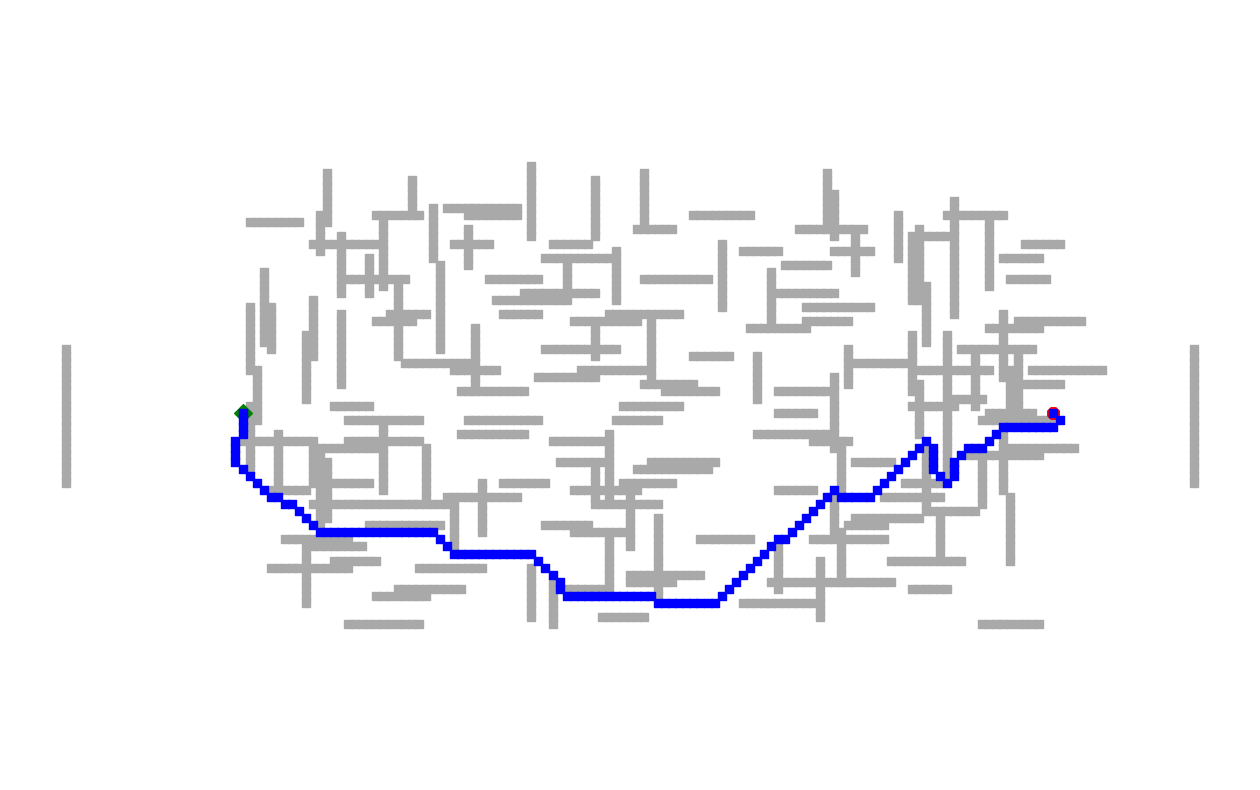

In [ ]:
# TODO 18
solution = uniform_cost_search(d3)
plot_grid_problem(d3, solution, reached=None, title='Uniform cost search')

Greedy BFS search: 164.5 path cost
448 states reached


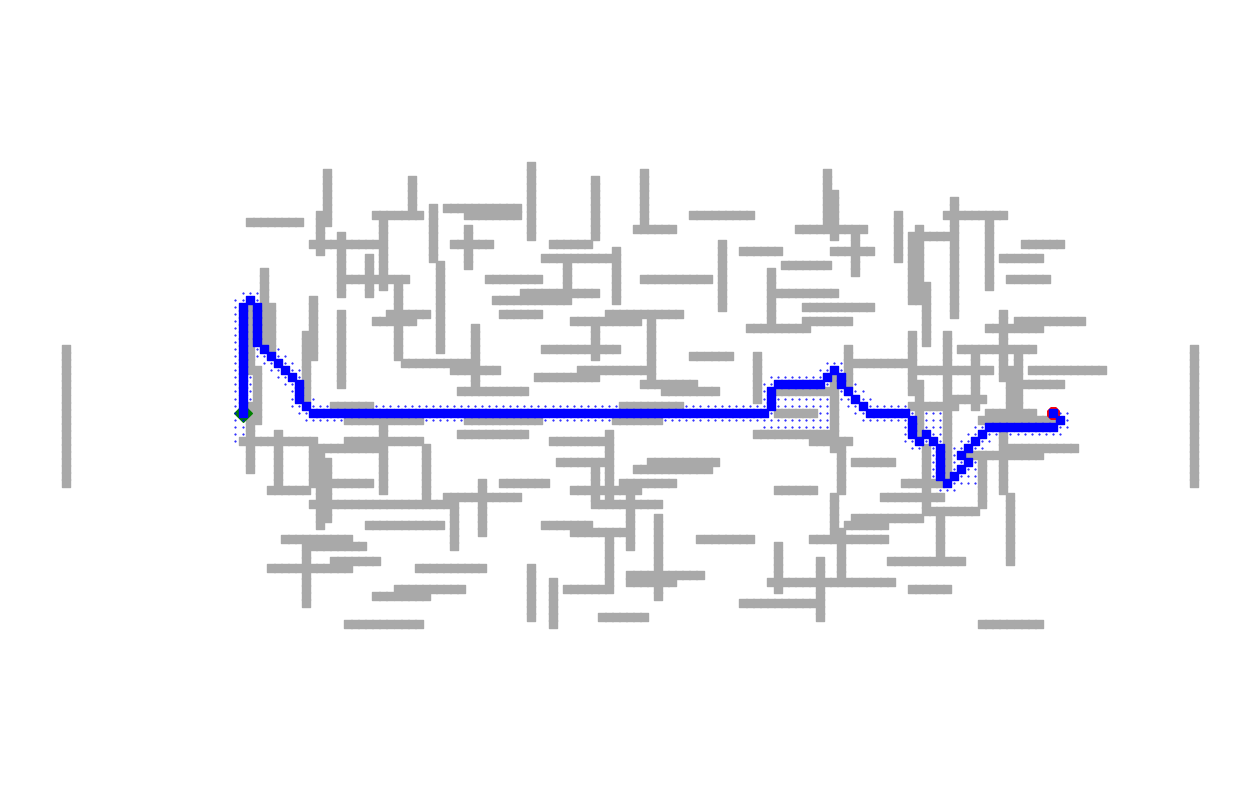

In [ ]:
# TODO 19
solution = greedy_bfs(d3)
plot_grid_problem(d3, solution, reached, 'Greedy BFS')

A* search search: 154.2 path cost
7,418 states reached


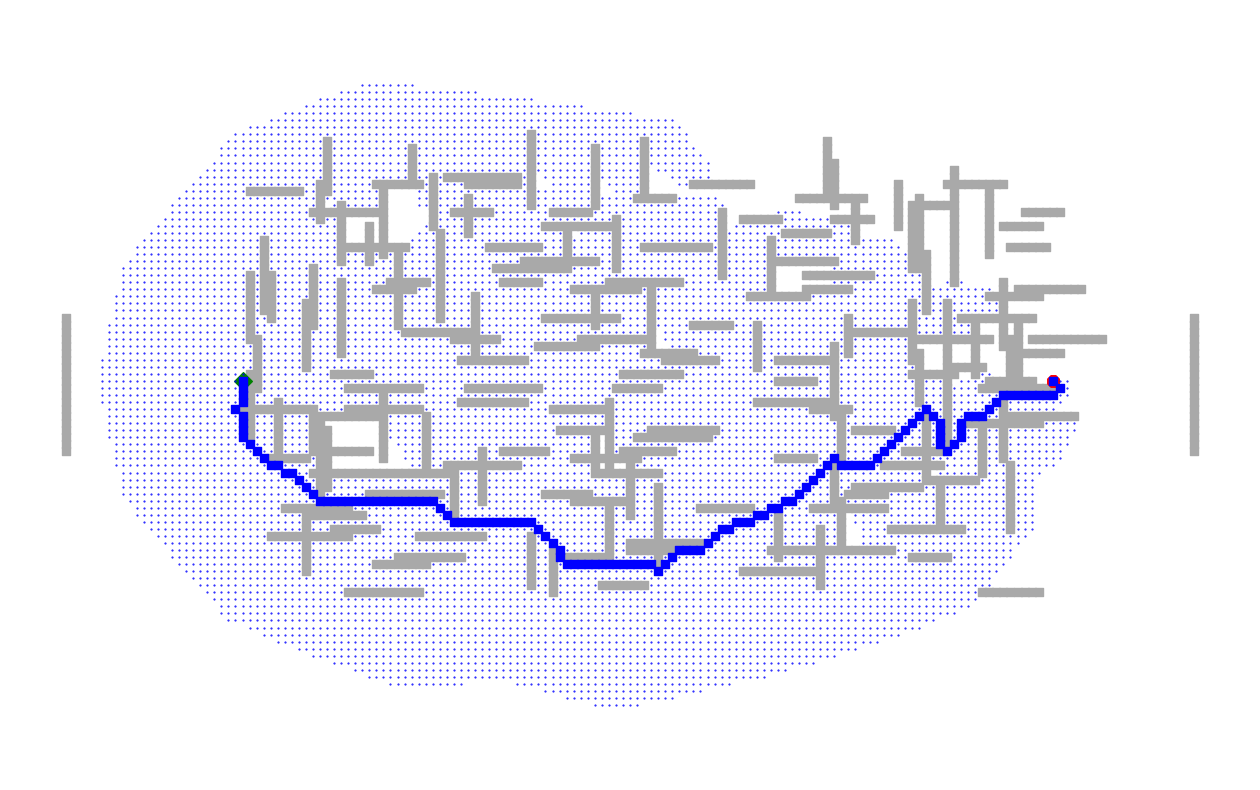

In [ ]:
# TODO 20
solution = astar_search(d3)
plot_grid_problem(d3, solution, reached, 'A* search')

Weighted A* search: 154.2 path cost
944 states reached


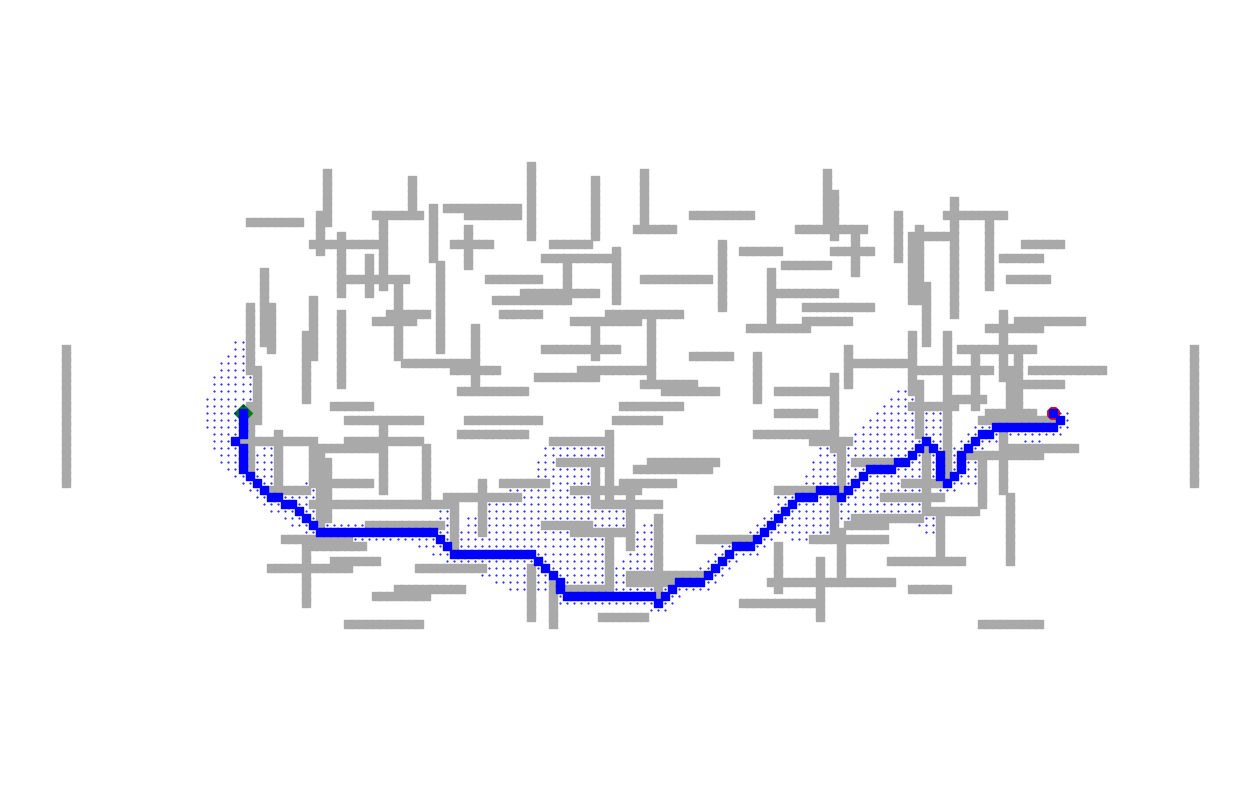

In [ ]:
# TODO 21
solution = weighted_astar_search(d3)
plot_grid_problem(d3, solution, reached, 'Weighted A*')

# 실습 과제

* 모든 문항 해결에 생성형 AI 사용 가능

### 1번

9 × 9 크기의 격자(grid)가 존재한다. 이 격자의 각 칸은 빨강 혹은 파랑으로 칠할 수  있다. 처음에는 모든 칸이 파랑으로 칠해져 있지만, 원하는 대로 색을 변경할 수 있다.

이 격자를 3 × 3 크기인 아홉개의 작은 격자(subgrid)로 나누었을 때, 각 작은 격자는 하나의 색으로 통일되어야 하며, 인접한 작은 격자들은 서로 다른 색을 가져야 한다.

1.  생성형 AI을 사용해 이 문제에 대한 problem formulation(initial state, goal test, successor function, cost function)을 작성하고 이 문제의 state space 크기를 출력하도록 요청하시오.

  * 생성형 AI에 입력한 프롬프트와 생성형 AI의 출력을 붙여넣고, 내용을 참고하여 응답을 작성하시오. 해당 답이 올바른지 평가하고, 평가에 대한 이유를 제시하시오.

2. 각 칸의 색을 단 한 번만 색칠할 수 있다고 가정한다. 칸을 두 번 색칠하는 것을 방지하기 위해, 1) 이미 색칠된 정사각형을 기록하여 다시 색칠하지 못하도록 하거나, 2) 모든 정사각형을 고정된 순서로 색칠할 수 있다.

  * 생성형 AI을 사용해 **이 두 경우에 대해** problem formulation(initial state, goal test, successor function, cost function)을 다시 **각각** 작성하고, state space의 크기를 다시 **각각** 계산하시오. 두 상황 중 어느 접근의 state space 크기가 더 작은가?

    * 생성형 AI에 입력한 프롬프트와 생성형 AI의 출력을 붙여넣고, 내용을 참고하여 응답을 작성하시오. 해당 답이 올바른지 평가하고, 평가에 대한 이유를 제시하시오.

3. 기존 문제는 격자의 각 칸 하나를 색칠하는 경우를 고려하였다. 그런데 이제 각 작은 격자(subgrid)가 균일한 색으로 칠해진 경우를 가정한다.

  * 생성형 AI을 사용해 위 상황에 대한 problem formulation(initial state, goal test, successor function, cost function)을 다시 작성하고, state space의 크기를 다시 계산하시오. 위 상황같이 개별 칸을 고려하는 것 보다 각 작은 격자를 고려하는 접근의 이점은 무엇인가?

    * 생성형 AI에 입력한 프롬프트와 생성형 AI의 출력을 붙여넣고, 내용을 참고하여 응답을 작성하시오. 해당 답이 올바른지 평가하고, 평가에 대한 이유를 제시하시오.

4. 이 문제에는 몇개의 해답이 존재하는가? 그 이유는 무엇인가?

  * 생성형 AI에 입력한 프롬프트와 생성형 AI의 출력을 붙여넣고, 내용을 참고하여 응답을 작성하시오. 해당 답이 올바른지 평가하고, 평가에 대한 이유를 제시하시오.



----아래 답변 작성----

# 문제 정리
- 전체 격자: 9행 * 9열 = 81개의 셀

- 묶는 단위: 3*3 크기의 블록(subgrid)

- 묶는 방식: 9개의 subgrid, 3*3

- 결과: 전체를 3행 3열의 subgrid 9개로 분할하는 것


# 1-1) 생성형 AI 프롬프트 및 출력
Q. 이 문제에 대한 problem formulation(initial state, goal test, successor function, cost function)을 작성해보고 이 문제의 state space 크기를 출력해봐

A.

✅ 1. Initial State (초기 상태)
**9×9 격자(grid)**의 모든 칸이 파랑(B) 으로 채워진 상태
따라서 각 subgrid 9개 모두가 현재는 파랑색으로 채워져 있음

✅ 2. Goal Test (목표 상태 판별)
다음 조건을 모두 만족하는 상태를 Goal로 본다:

각 3×3 subgrid는 모두 동일한 색이어야 한다. (즉, 하나의 subgrid는 오직 R 또는 B 중 하나로만 칠해져야 함)
서로 인접한 subgrid는 서로 다른 색이어야 한다.
인접이란 상하좌우로 연결된 subgrid만 해당됨 (대각선은 인접 아님)

✅ 3. Successor Function (상태 전이 함수)
현재 상태에서 가능한 다음 상태를 반환함.
즉, 각 subgrid에 대해 색을 하나씩 정해주는 방식
가능한 색: 빨강(R), 파랑(B)
단, 이미 색이 정해진 subgrid는 변경 불가

✅ 4. Cost Function (비용 함수)
모든 이동의 비용은 동일하다고 가정 → Uniform Cost (1 per move)
즉, 단순히 goal에 도달하는 것이 목적이라면 비용은 상태 깊이와 동일

📦 State Space 정의

이제 상태 공간의 크기를 계산해보자.

🔸 Key 관찰:
각 subgrid는 전체가 동일한 색이어야 하므로,
격자 전체의 상태는 단순히 9개의 subgrid가 어떤 색인지로 표현 가능함.
각 subgrid는 R 또는 B → 가능한 상태는 2개의 색 중 하나
단, 모든 경우가 goal state가 아님 (제약 조건 존재)
❌ 총 상태 수 (제약 조건 없는 경우)
색이 두 가지(R, B), subgrid가 9개 →
전체 가능한 상태 수는:
2^9=512


A.결론

문제에서 정의했듯이, 상태는 9원소 튜플. 초기 상태는 모든 칸이 파란색을 칠해져 있는 상태다. 우리의 목표는 각 3*3의 각칸을 색칠하되 인접한 칸은 서로 다른 색으로 칠하는게 목표이므로 goal test역시도 올바르다고 볼 수 있다. 각 격자를 서로 다른 색으로 색칠을 하고 후속적으로 할 수 있는 작업은 색칠된 격자를 다른 색으로 바꾸는 것이다.
문제에서 비용함수는 따로 정의되지 않았으므로 생성형 AI의 출력이 타당하고 판단하긴 어렵다.

결국 이러한 problem formulation을 참고해서 AI가 출력한 state space는 2의9승으로 512가 맞다. 인접한 격자의 색이 달라야 한다는 것은 퍼즐의 어떤 상태가 goal state인지 판별하는 것이지 탐색하는 상태공간을 줄이는 것에 영향을 끼치는 것은 아니기 때문에, 또 각 3*3 subgrid는 내부적으로 모두 같은 색이어야 하므로 올바르다고 볼 수 있다.  




# 1-2) 생성형 AI 프롬프트 및 출력
Q.
 자 그럼 이 문제에서 각 칸의 색을 단 한 번만 색칠할 수 있다고 가정해보자. 칸을 두번 색칠하는 것을 방지하기 위해 첫번째로 이미 색칠된 정사각형을 기록하여 다시 색칠하지 못하도록 하거나 모든 정사각형을 고정된 순서로 색칠 할 수 있어 이 조건을 추가해서 problem formulation(initial state, goal test, successor function, cost function)과 state space의 크기를 두 경우 각각 계산해봐


**A-1(이미 색칠된 칸 기록)**

색칠 순서를 자유롭게 정하고, 이미 색칠된 칸은 다시 색칠할 수 없도록 기록한다.”

1. Initial State
모든 칸이 미색칠 상태.
visited(혹은 colored) 집합(또는 맵) = 비어 있음 (즉, 아직 아무 칸도 칠하지 않음).
2. Goal Test
81칸 모두 색칠이 완료됨.
모든 3×3 subgrid는 내부적으로 하나의 색으로만 구성.
인접 subgrid끼리는 색이 달라야 함.
3. Successor Function
미색칠인 칸 중 하나를 임의로 선택한다.
그 칸을 빨강(R) 또는 파랑(B) 중 하나로 칠한다.
해당 칸을 visited에 등록(“이미 색칠됐다”고 기록).
이미 visited에 있는 칸(즉, 색칠된 칸)은 다시 색칠 불가능.
즉, 어떤 시점에서든 아직 칠하지 않은 칸을 골라 2가지 색 중 하나로 칠하는 방식으로 새 상태를 만든다.

4. Cost Function
칸 1개 색칠할 때마다 비용을 1로 둔다.
전체 81칸을 모두 색칠 완료하면, 총 비용은 81이 될 것이다.
5. State Space 크기
중간 상태까지 포함하여 “(미색칠 / R / B)”를 각 칸이 가질 수 있다고 보면,
이론상 상태 수는
3
81

 .
(각 칸마다 3가지 상태: 안 칠함 / R / B)




**A-2(고정된 순서로 칸 색칠)**

“왼쪽 위 칸부터 오른쪽 아래 칸까지 고정된 순서로 색칠한다.”

1. Initial State
모든 칸 미색칠 상태.
현재 색칠해야 할 칸의 인덱스를 0이라 둔다.
(예: (0,0)을 0번 칸, (0,1)을 1번 칸 … (8,8)을 80번 칸 등으로 매핑)
2. Goal Test
81번째 칸(인덱스 80)까지 색칠을 마쳤고,
모든 3×3 subgrid가 단일 색이며,
인접 subgrid끼리는 서로 다른 색.
3. Successor Function
현재 인덱스 i의 칸을 R 또는 B 중 하나로 칠한다.
i를 i+1로 증가시켜 “다음 칸”으로 이동.
이미 색칠 완료한 인덱스 i로 되돌아가서 덮어쓰기 불가(한 번만 색칠).
즉, (i=0) → (i=1) → … → (i=80) 순으로 일방통행하며 색칠을 진행한다.

4. Cost Function
칸 1개 색칠 시 비용 1.
81칸 모두 색칠하면 비용 81.
5. State Space 크기
중간 상태를 “i번째 칸까지 색칠 완료, 나머지는 미색칠”이라고 볼 때,
각 칸은 R 또는 B → i번째 칸까지 색칠된 경우의 수는
2
i
2
i
 .
i는 0에서 81까지 증가.
따라서 모든 중간 상태 개수는
∑
i
=
0
81
2
i

=

2
82
−
1.
i=0
∑
81
​
 2
i
 =2
82
 −1.
이와 달리 최종 결과(81칸이 전부 색칠된 완성 상태)만 보면 마찬가지로
2^81

가지가 가능하다.



# 결론

두 경우를 비교하면 고정된 순서로 칸을 색칠하는 2번째 방식이 state space가 더 작다. 두 경우 모두 재칠이 불가능하다는 제약은 동일하지만
첫 번째 경우는 아직 색칠되지 않은 격자(실제로는 파랑색으로 색칠되어있음)은(는)어느 것이든 골라서 색을 칠할 수 있고 이를 기록한다. 이때 첫 번째 경우는 아무 행동도 하지 않는 None, 파랑, 빨강을 칠하는 행동을 할 수 있는 3의 81승의 state space가 나오는 것이 맞고. 두 번째 경우는 칠할 순서를 고정해 둠으로써 그 시점에 칠할 결자를 빨강 또는 파랑 으로 결정하는 두가지 선택지 뿐이고, 공통 제약 조건으로써 한번 칠한 격자는 칠할 수 없으니 state space는 1(아무행동도 하지 않음)+2(첫번째 격자를 빨강 또는 파랑으로 칠함) +2의2승+....+2의81승= state space가 나온다.

즉 고정된 순서 없이 자유롭게 색칠하고 이를 기록하는 경우는 각 격자당 3가지 경우를 배정해 나가서 훨씬 많은 상태가 생기는 것이 맞고, 순서를 정해두는 두 번째 경우는 각 순서에 맞는 격자당 2가지 색 중 하나를 고르는 이지 선다로 state가 탐색되기 때문에 1번에 비해 전체 상태공간이 훨씬 적어지는 것이다. 따라서 2번째 경우가 state space가 더 적다는  AI의 답변은 타당하다.






# 1-3) 생성형 AI 프롬프트 및 출력

Q. 지금까지의 문제는 격자의 각 칸 하나를 색칠하는 경우를 고려했잖아. 그런데 이제는 각 작은 격자가 균일한 색으로 칠해진 경우를 가정해볼꺼야 이 상황에 대해 problem formulation(initial state, goal test, successor function, cost function)을 다시 작성하고, state space의 크기를 다시 계산해봐 그리고 이 접근 방식의 이점은 뭘까?



A.

2.Problem Formulation

2.1. State(상태)의 표현
State를 “9개의 subgrid 각각이 (미정 / R / B) 중 어떤 상태인지”로 정의할 수 있음.
탐색 도중에는 아직 색이 정해지지 않은 subgrid가 있을 수 있기에,
각 subgrid가
{
uncolored
,
R
,
B
}
{uncolored,R,B} 셋 중 하나를 가질 수 있다고 보면 됨.

2.2. Initial State
9개 subgrid가 전부 ‘미정’(uncolored) 상태로 시작한다.

2.3. Goal Test

9개 subgrid가 모두 R 또는 B로 색이 정해졌으며,
인접 subgrid끼리는 서로 다른 색을 가진다.
(subgrid 내부 균일 색은 이미 각 subgrid 전체를 R/B로 결정하는 것이므로 자연스럽게 충족)

2.4. Successor Function
아직 색이 정해지지 않은 subgrid 중 하나를 골라,
R 또는 B 중 하나를 할당(색칠)한다.
이렇게 해서 다음 상태를 생성한다.
즉, 한 번의 “이동(move)”는 **“특정 subgrid에 R 또는 B 색을 정해주는 것”**이라고 볼 수 있음.

2.5. Cost Function
일반적으로 각 subgrid에 색을 정하는 데 비용 1로 둘 수 있다.
최종적으로 9개 subgrid를 모두 칠하면 비용의 합은 9가 됨.
(물론 다른 방식으로 Cost를 정의해도 무방하나, 보통 균등 비용을 많이 가정)

3. State Space 크기

3.1. 전체 가능한 상태(부분 포함)
각각의 subgrid가 “미정 / R / B” 3가지 중 하나를 가질 수 있다고 보면,
가능한 모든 조합은
3
9
 .
(3×3×...×3, 9번 곱)
3.2. 완성된 색 배치(Goal 후보)만 놓고 보면
모든 subgrid가 R 또는 B로 결정 →
2
9
=
512

이 512가지 중, 인접 subgrid가 다른 색이라는 조건을 만족하는 것은 실제로 극히 일부(실제로는 2가지)만 유효해진다.
3×3 형태로 인접한 9개 블록을 2색으로 칠하는 것은 이분 그래프 색칠 문제와 동일 → 가능한 해가 2가지뿐(체스보드형).

✅ 작은 격자(subgrid) 단위로 접근하는 이점

1. 문제의 추상화 수준이 높아짐 (복잡도 감소)
개별 칸으로 구성하면 81개의 칸을 고려해야 하며, 그만큼 상태 공간이 폭발적으로 커집니다.
예: 81칸 × 2색 = 2⁸¹개의 조합
반면, subgrid 9개를 단위로 하면 단 9개의 단위만 고려하면 됨.
상태 공간 = 2⁹ = 512
→ 문제를 작게 단순화하여 핵심 로직에 집중할 수 있게 함

2. 색 일관성이 보장됨
subgrid 내부가 단색(R/B)이라는 전제가 있을 경우, 개별 칸을 신경 쓸 필요 없이, subgrid 전체를 한 색으로 보는 것이 논리적으로 타당하고, 계산량을 대폭 줄임.

3. 탐색 트리의 깊이 감소
개별 칸을 칠하는 탐색은 깊이가 81이지만, subgrid 단위로 하면 깊이가 9로 줄어듬.
이는 탐색 알고리즘(BFS, DFS, 백트래킹 등)의 효율에 직접적인 영향을 줌.


**결론**

초기 상태는 모든 subgrid가 미정이고, 목표 상태는 모든 subgrid가 R 또는 B로 정해졌으며 인접한 것끼리 색이 다른 상태다. 상태 전이는 아직 색이 정해지지 않은 subgrid 하나를 골라 R 또는 B를 칠하는 방식이며, 한 번의 이동 비용은 1로 본다.

전체 state를 탐색하여 나오는 공간은 3⁹ = 19,683가지이고, 모든 subgrid가 색이 정해진 완성 상태는 2⁹ = 512가지이다. 하지만 이 중에서 인접 조건을 만족하는 유효한 색 배치는 단 2가지뿐이다. 이는 3×3 격자가 이분 그래프 구조를 가지며, 이분 그래프는 인접한 정점끼리 두 가지 색으로만 색칠할 수 있기 때문이다.

또 개별 칸을 기준으로 보면 "왼쪽 위 칸이 빨간색
이면 오른쪽 칸은 파랑색이어야하고 그 아래 칸도 파랑색"이어야 하는 식의 조건이 많고 복잡해지지만 "subgrid의 기준으로 보면 subgrid1이 빨강이면 인접한 subgrid 2,4는 파랑이어야 한다" 와 같이 조건이 훨씬 직관적이게 되므로 복잡도과 state의 크기가 줄어든다는 AI의 답변은 타당하다고 볼 수 있다.




# 1-4) 생성형 AI 프롬프트 및 출력

Q. 지금까지 보면 균일한 색으로 칠해진 경우, 칸을 두번 색칠하는 걸 방지하게 위해 색칠된 정사각형을 기록하는 경우, 고정된 순서로 칸을 색칠하는 경우, 그냥 보통 경우 등등 다양한 경우에 대해서 problem formulation을 작성하고 state를 계산해봤어 이 문제에는 몇개의 해답이 있을까?

A.

질문에서 "이 문제"라고 하신 부분은, 지금까지 주로 다뤄왔던 아래 조건을 따른다고 볼 수 있습니다:

3×3 subgrid 구조
각 subgrid는 균일한 색 (R 또는 B)
인접한 subgrid는 서로 다른 색
초기에는 전부 B로 칠해져 있음 (또는 미정일 수 있음)
최종 상태에서 모든 subgrid가 R 또는 B로 칠해져야 함.

🎯 이 문제의 해답 수

🔷 본질: 이분 그래프의 2-색칠 문제
3×3 격자를 정점 9개짜리 그래프로 보고, 인접한 subgrid에 간선을 연결한 그래프는 이분 그래프입니다.
이분 그래프는 정확히 2가지 방식으로만 2색 칠하기가 가능합니다.

🔷 즉, 가능한 해답은 2가지
체스보드 패턴처럼 번갈아가며 칠하는 두 가지 경우:
(0,0) 위치를 R로 시작 → 체스보드 패턴
(0,0) 위치를 B로 시작 → 반대 체스보드 패턴

A. 결론적으로,9×9 격자는 총 2⁸¹개의 색칠 조합을 가질 수 있지만, 각 3×3 subgrid가 단일 색을 가져야 하므로 가능한 조합은 2⁹로 줄어든다. 여기에 인접한 subgrid끼리는 서로 다른 색을 가져야 한다는 제약이 추가되면, 이는 전형적인 이분 그래프 2-색 칠하기 문제로 볼 수 있다. 3×3 구조는 이분 그래프 구조를 이루기 때문에, 조건을 만족하는 색칠 방법은 두 가지 경우뿐이다. 따라서 이 문제의 해는 2가지만 존재한다고 하는 AI의 답변은 타당하다.

case 1)

R B R

B R B

R B R

case 2)


B R B

R B R

B R B

### 2번

### 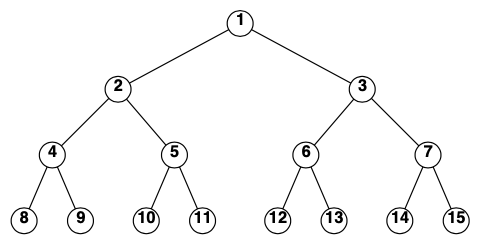

Initial state이 1이며 goal state은 11일때, 1) breadth-first search, 2)  limit이 3 인 depth-limited search, 3) iterative deepening search을 실행했을 때 방문하게 되는 노드 번호를 각 탐색 알고리즘마다 작성하시오.

----아래 답변 작성----

**1) Breadth-first search**

Bfs는 깊이 순으로 탐색하는 알고리즘. 그렇게 때문에 깊이 0인 노드 탐색, 깊이 1인 노드 탐색, 깊이 2인 노드 탐색의 순으로 탐색이 진행된다. 따라서 노드 탐색 순서는 다음과 같다.

1 > 2 > 3 > 4 > 5 > 6 > 7 > 8 > 9 > 10 > 11(Goal state) 탐색 종료

**2) depth-limited search**

DFS처럼 왼쪽 노드부터 탐색하지만 깊이가 3이라는 제한 조건이 있음.
따라서 탐색은 최대 깊이 3까지만 탐색이 진행됌.
initial state의 왼쪽 노드부터 탐색 진행.
1 > 2 > 4 > 8 > 9 > 5 > 10 > 11(Goal state) 탐색 종료

**3) iterative deepening search**

깊이를 0부터 시작해 깊이 제한 탐색을 하고 탐색이 끝날 때 마다 깊이를 1씩 늘려가며 탐색하는 알고리즘.

Depth = 0

1

Depth = 1

1 > 2 > 3

Depth = 2

1 > 2 > 4 > 5 > 3 > 6 > 7

Depth = 3

1 > 2 > 4 > 8 > 9 > 5 > 10 > 11(Goal state) 탐색 완료



### 3번

GridProblem의 `d6`, `d7` 그리드에 1) `greedy_bfs`, 2) `astar_search`, 3) `weighted_astar_search` with weight `1.4`, 4) `weighted_astar_search` with weight `2`을 적용하여 탐색의 결과를 출력하시오. 출력된 결과를 바탕으로 각 알고리즘의 optimality와 reached state의 크기를 비교분석하시오.

**grid problem with d6**

Greedy BFS search: 133.9 path cost
758 states reached


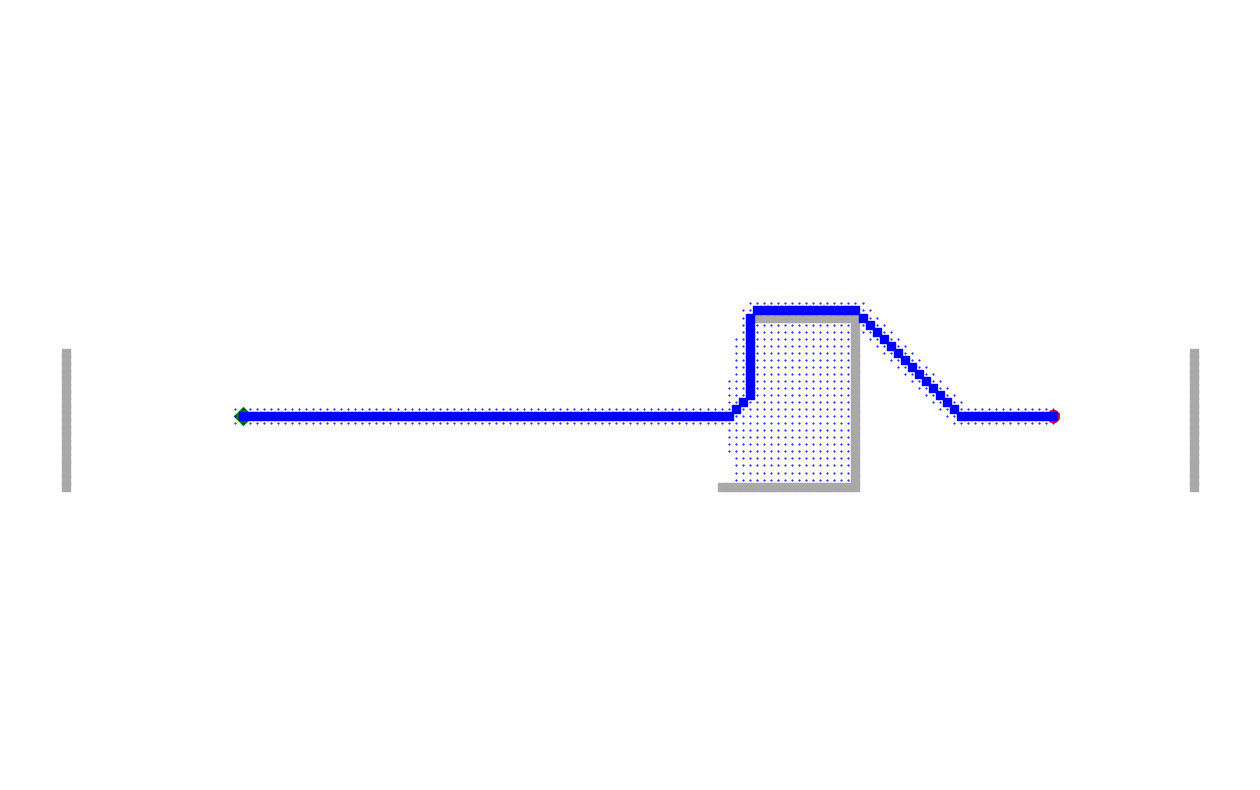

In [ ]:
# Greedy_bfs with d6
solution = greedy_bfs(d6)
plot_grid_problem(d6, solution, reached, 'Greedy BFS')

A* search search: 124.1 path cost
3,305 states reached


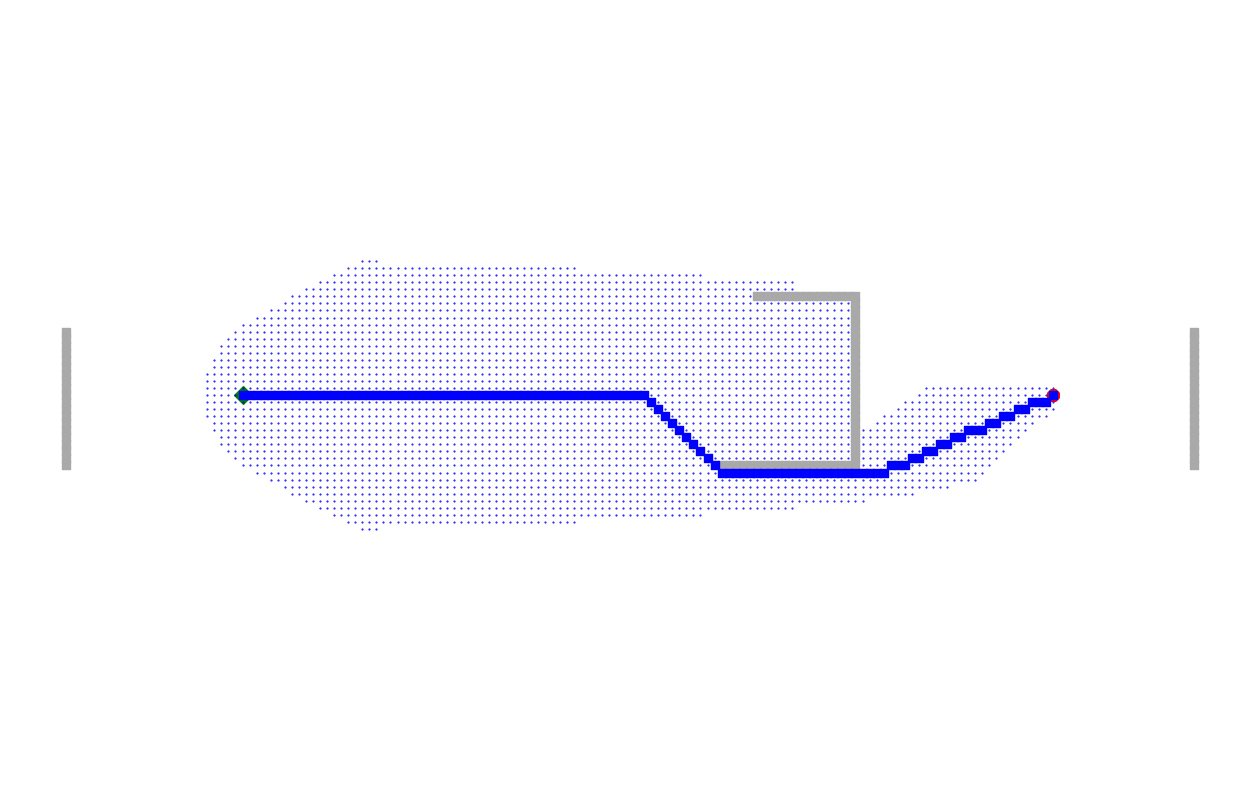

In [ ]:
# astar_search with d6
solution = astar_search(d6)
plot_grid_problem(d6, solution, reached, 'A* search')

Weighted A* search: 124.1 path cost
976 states reached


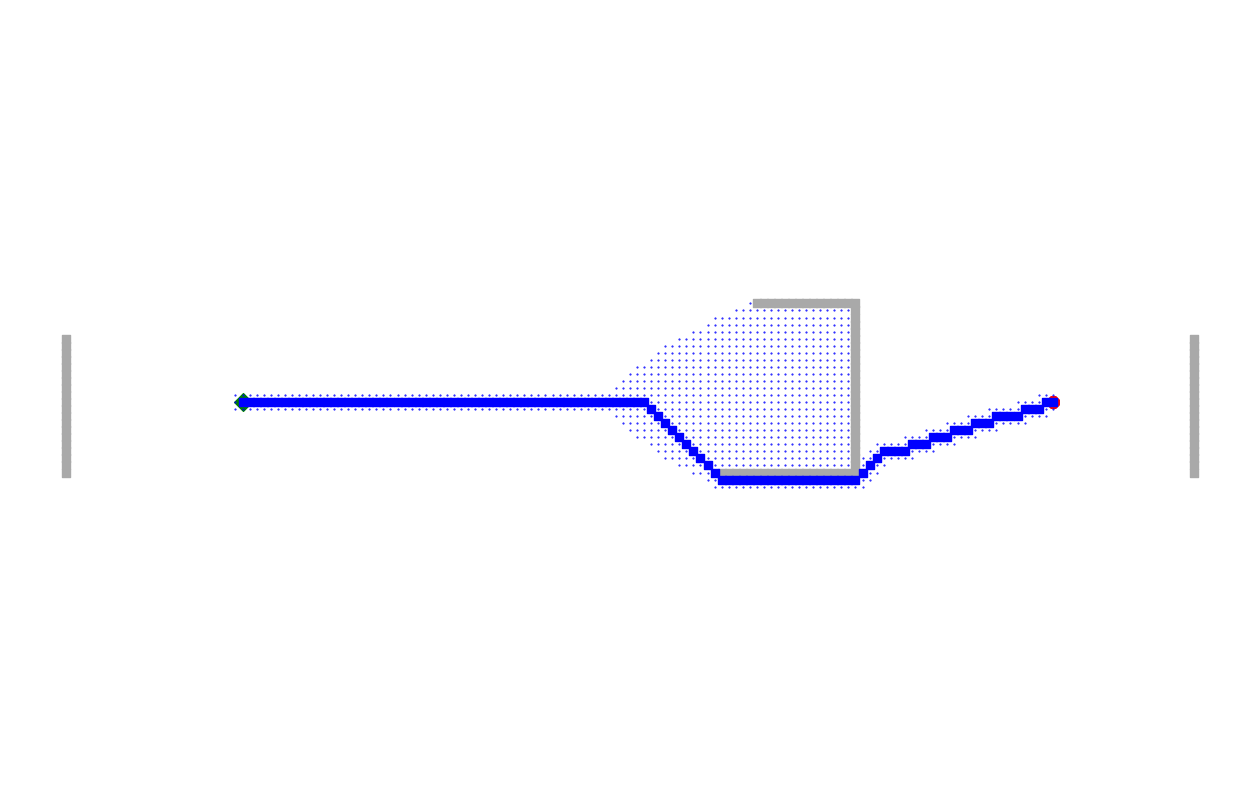

In [ ]:
# weighted_astar_search_weight 1.4 with d6
solution = weighted_astar_search(d6)
plot_grid_problem(d6, solution, reached, 'Weighted A*')

In [ ]:
# weighted_astar_search_weight 2 with d6
def weighted_astar_search(problem, h=None, weight= 2):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))

Weighted A* search: 128.6 path cost
879 states reached


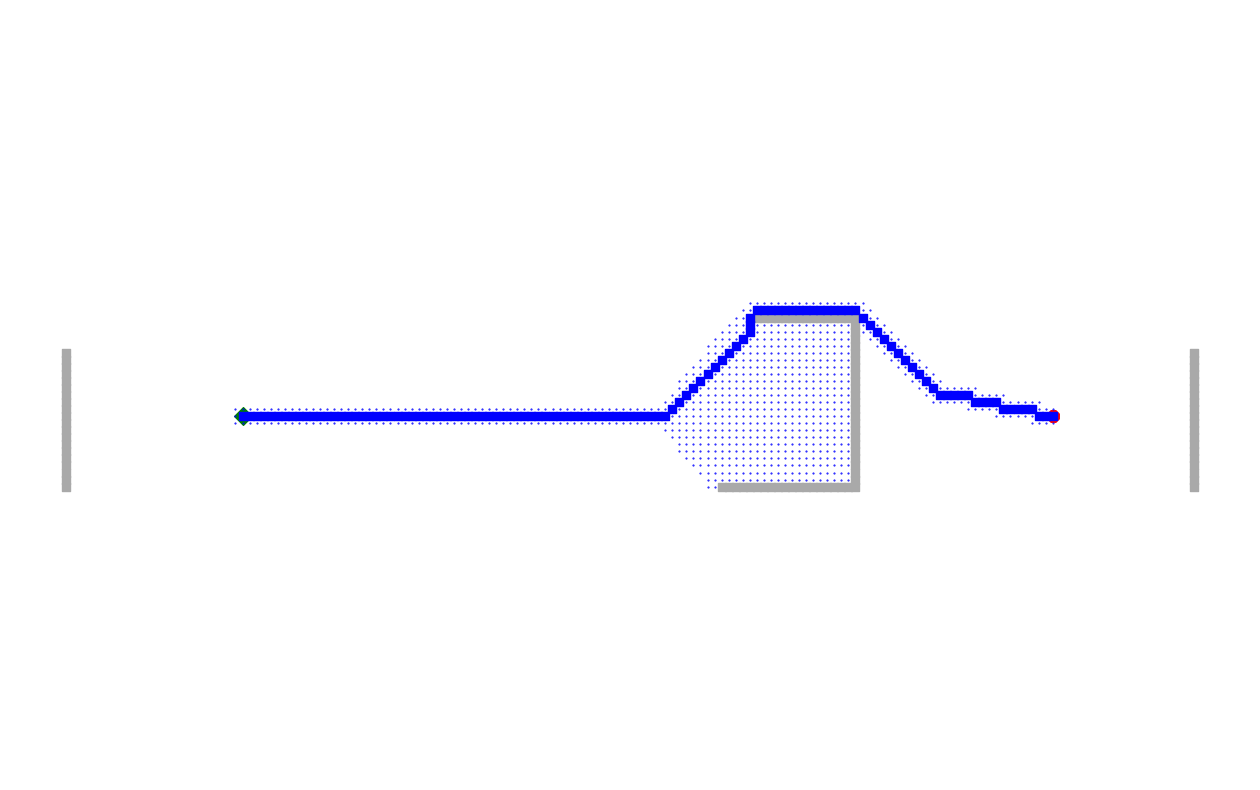

In [ ]:
# weighted_astar_search_weight 2 with d6
solution = weighted_astar_search(d6)
plot_grid_problem(d6, solution, reached, 'Weighted A*')

d6 격자에서 네 가지 탐색 알고리즘(Greedy BFS, A* Search, Weighted A*(w=1.4), Weighted A*(w=2))을 적용한 결과 Optimality 와 Reached State 크기 측면에서 차이를 보여준다.

 **Greedy BFS**는 휴리스틱만을 사용해 목표와 가까워 보이는 경로를 우선 확장하기 때문에 가장 적은 상태(758개)를 방문하며 탐색을 빠르게 끝내지만, 실제 비용을 고려하지 않아 경로 비용이 133.9로 네 알고리즘 중 가장 높은 값이 나온다.

 반면, **A* Search** 는 initial state의 누적 비용 g(n)과 휴리스틱 h(n)을 합한 f(n)로 노드를 확장하여 최적 비용을 보장하지만, 그 대가로 state을 3305개나 방문한다. 이때 A가 찾은 경로 비용은 124.1로 최적임을 확인할 수 있다.

  **Weighted A(w=1.4)**는 A와 마찬가지로 124.1의 최적 비용을 찾았음에도 휴리스틱에 가중치를 더해 탐색 범위를 줄였기에 방문 상태가 976개로 A보다 훨씬 적고 효율적이다. 단, 가중치가 더 큰 **Weighted A*(w=2)**는 방문 상태 수가 879개로 조금 더 줄어들지만 비용이 128.6으로 상승해 최적 비용에서 다소 벗어난다.


  정리하자면, Greedy BFS는 네 알고리즘 중 Reached state가 가장 적으나 비용이 가장 크고, A는 비용은 최소지만 방문한 State이 많으며, Weighted A는 가중치가 1.4일 때는 최적 비용을 유지하면서 방문 수를 크게 줄였고, 2로 올리면 방문한 State가 더 줄지만 비용이 올라가는 모습을 보인다.
  
  결과적으로 최적 비용을 절대적으로 추구한다면 A를 쓰는 것이 안전하고, 약간의 비용 손실을 감수하면서 탐색 속도를 높이고 싶다면 Weighted A를 적용할 수 있으며, 빠르게 대략적인 경로만 확보하고자 한다면 Greedy BFS가 유용하다는 결론을 내릴 수 있다.

**Grid problem with d7**

Greedy BFS search: 151.6 path cost
830 states reached


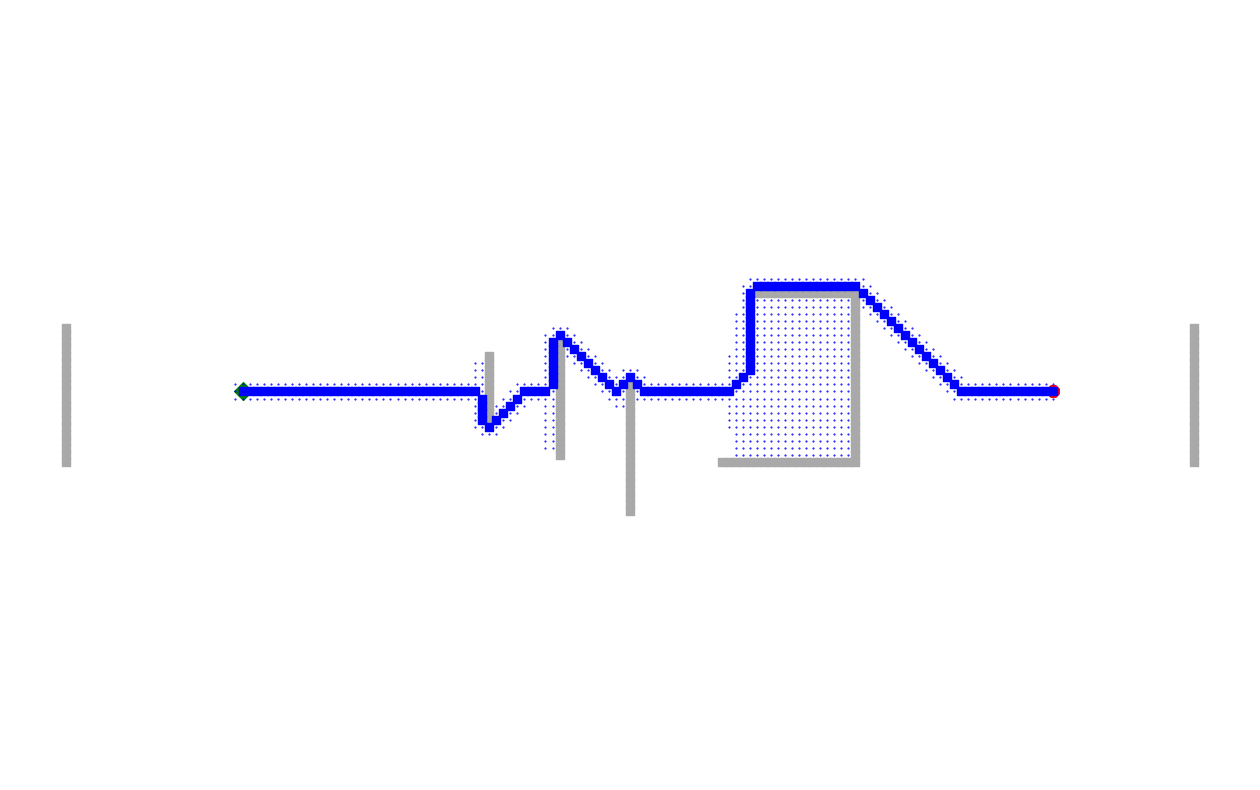

In [ ]:
# Greedy_bfs with d7
solution = greedy_bfs(d7)
plot_grid_problem(d7, solution, reached, 'Greedy BFS')

A* search search: 127.4 path cost
4,058 states reached


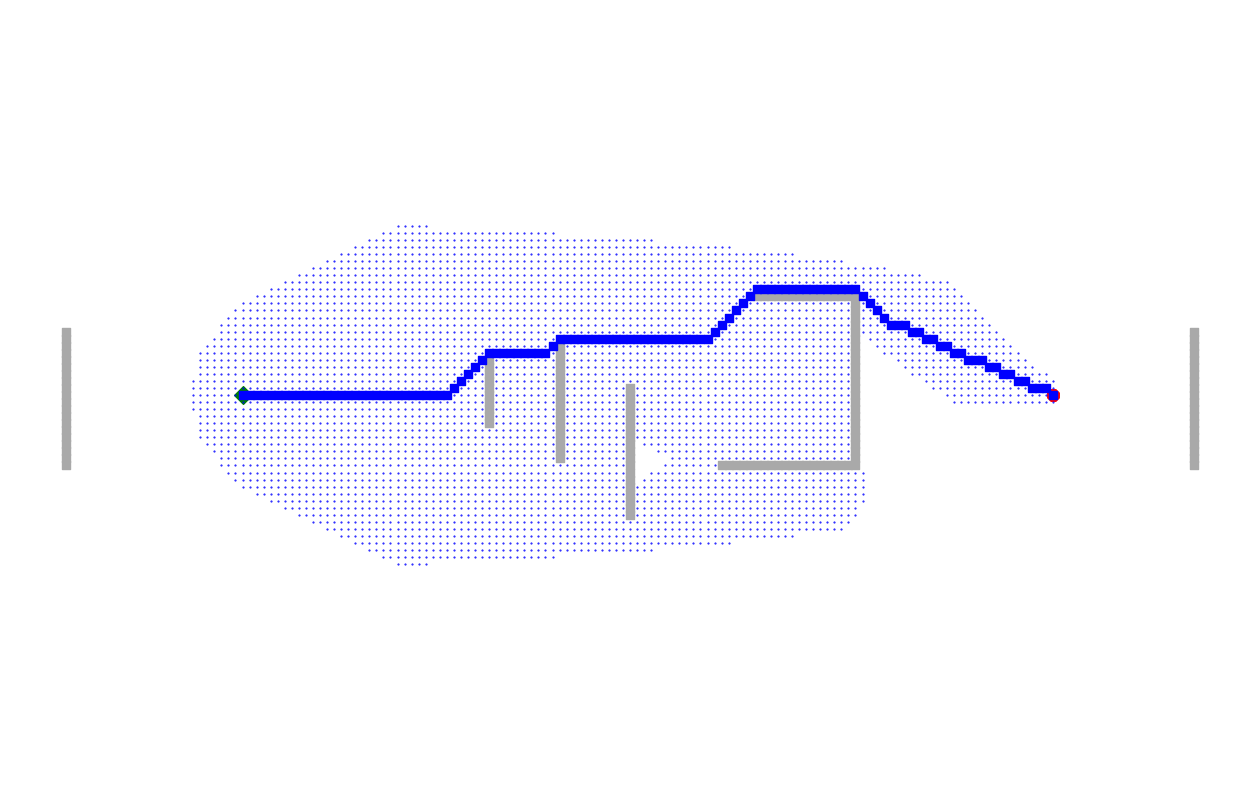

In [ ]:
# astar_search with d7
solution = astar_search(d7)
plot_grid_problem(d7, solution, reached, 'A* search')

Weighted A* search: 140.4 path cost
980 states reached


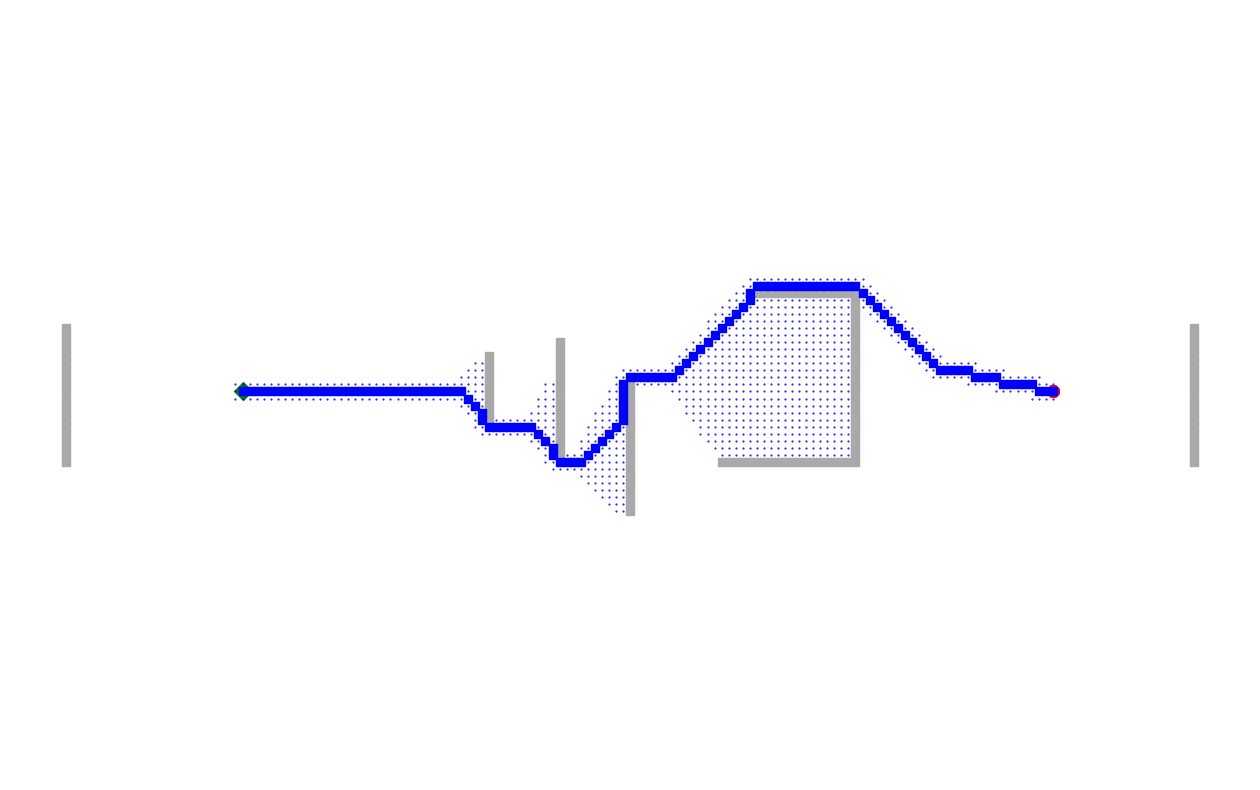

In [ ]:
# weighted_astar_search_weight 2 with d6
solution = weighted_astar_search(d7)
plot_grid_problem(d7, solution, reached, 'Weighted A*')

In [ ]:
# weighted_astar_search_weight 1.4 with d6
def weighted_astar_search(problem, h=None, weight= 1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))

Weighted A* search: 127.4 path cost
1,290 states reached


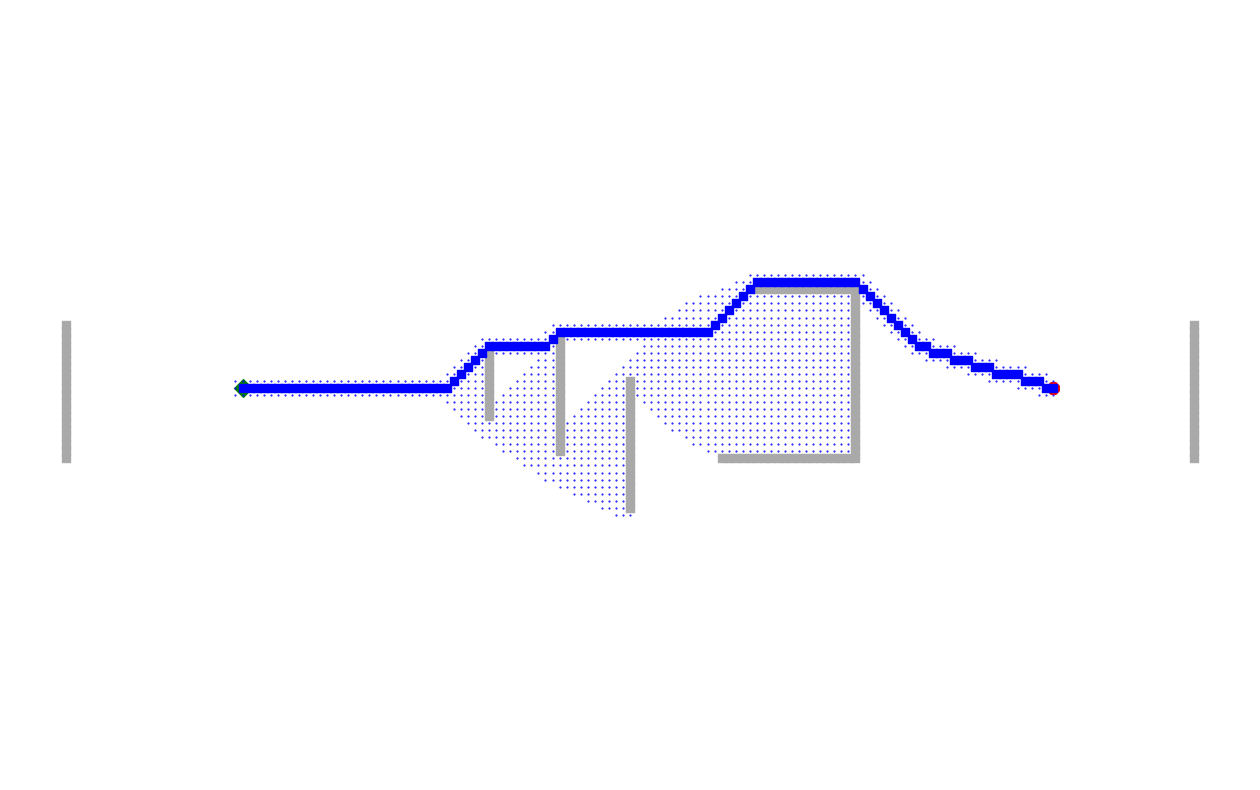

In [ ]:
# weighted_astar_search_weight 1.4 with d6
solution = weighted_astar_search(d7)
plot_grid_problem(d7, solution, reached, 'Weighted A*')

d7 격자에서 **Greedy BFS**는 휴리스틱에만 의존해 목표에 가까워 보이는 경로를 우선적으로 찾기 때문에 830개의 상태만 방문하면서 가장 적은 탐색 규모를 보이지만, 경로 비용이 151.6으로 네 알고리즘 중 가장 비싸다.

 **A* search**는 누적 비용 g(n)에 휴리스틱 h(n)을 합산해 최적 비용을 보장하려다 보니 무려 4058개의 상태를 방문하며 탐색량이 가장 많지만, 경로 비용을 127.4로 억제해 최적 해를 확보한다.

  **Weighted A(w=2)**는 가중치가 크기 때문에 A보다 상태 방문이 훨씬 적어 980개에 그치지만, 그만큼 경로 비용이 140.4로 올라가 어느 정도 최적성에서 멀어진다.
  
   반면 **Weighted A(w=1.4)**는 127.4로 A와 동일한 최소 비용을 내면서도, 방문 상태는 1290개로 A보다 훨씬 적은 전형적인 휴리스틱 가중의 이점을 보여준다.
  
  결국 d6 그리드와의 알고리즘 결과와 비슷하게 최적 비용감소를 절대적 우선순위로 둔다면 A를 사용할 수 있고, 약간의 비용 손실을 감수하고 탐색 규모를 줄이려면 Weighted A(w=2)를, 최적 비용을 얻으면서도 A보다 탐색을 크게 줄이려면 Weighted A(w=1.4)를 활용할 수 있으며, Greedy BFS는 가장 빠른 탐색을 제공하지만 비용 측면에서 크게 손해를 본다는 점에서 Optimality(최적)하지 않다고 할 수 있다.

### 4번

In [ ]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal

    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]

    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)

    def h1(self, node):
        """The misplaced tiles heuristic."""
        return misplaced_tiles_heuristic(node.state, self.goal)

    def h2(self, node):
        """The Manhattan heuristic."""
        return manhattan_distance_heuristic(node.state, self.goal)

    def h(self, node): return EightPuzzle.h2(self, node)


def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))


def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

class Board(defaultdict):
    empty = '.'
    off = '#'
    def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height)
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

    def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty

    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))

    def __hash__(self):
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

In [ ]:
e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))

In [ ]:
print(board8(e1.initial))

1 4 2
_ 7 5
3 6 8



1-1) 생성형 AI에게 문제를 설명하고, 아래의 `misplaced_tiles_heuristic와` `manhattan_distance_heuristic` 함수들을 구현하도록 요청하시오. 생성형 AI의 출력을 첨부하시오.

*   `misplaced_tiles_heuristic(A, B)`: 잘못 배치된 타일의 수(공백 미포함)
*   `manhattan_distance_heuristic(A, B)`: 타일의 목표 위치로부터의 거리의 합. 타일은 대각선을 따라 이동할 수 없기 때문에 거리는 가로 및 세로 거리의 합이다.


1-2) 생성형 AI가 출력한 코드의 동작 원리를 "본인의 언어"로 설명하고, 생성형AI의 도움을 받아 각 함수의 역할과 알고리즘을 설명하는 function documentation을 작성하시오. 생성형 AI가 출력한 function documentation의 요소는 무엇이며 어떤 특징을 띄는가?

1-3) 생성형 AI의 도움을 받아 입력값의 범위를 충분히 cover하는 다양한 테스트 케이스를 설계하고 실행하여 함수가 올바르게 동작하는지 검증하시오.

1-4) 생성형 AI을 사용해 코드의 성능을 최적화하거나 가독성을 높일 수 있는 방법을 찾아보고, 개선된 버전이 존재한다면 이를 구현해보시오.

1-5) 초기 코드와 개선된 코드의 차이점을 설명하고, 어떤 점에서 코드가 향상되었는지 작성하시오.




In [ ]:
# 1-1)
def misplaced_tiles_heuristic(A, B):
  # 두 퍼즐 상태 간 잘못 배치된 타일의 개수 계산
  # 현재 퍼즐 상태 A와 목표 퍼즐 상태 B를 비교해 각 위치에서 타일의 번호가 다를 경우 잘못 배치된 타일의 수 누적 반환
  # A = 현재 퍼즐 상태
  # B = 목표 퍼즐 상태
  # int = 잘못 배치된 타일의 개수
    return sum(1 for i in range(len(A)) if A[i] != 0 and A[i] != B[i])

def manhattan_distance_heuristic(A, B):
  # 현재 퍼즐 상태 A의 각 타일에 대해 해당 타일이 목표 상태 B에서 있어야 할 위치까지의 거리 계산 후 반환
  # 매개 변수 동일
  # int = 모든 타일의 맨해튼 거리의 합
    distance = 0
    for i in range(len(A)):
        if A[i] != 0:
            goal_index = B.index(A[i])
            distance += abs((i // 3) - (goal_index // 3)) + abs((i % 3) - (goal_index % 3))
    return distance


1-2 )

동작 원리

이 코드는 앞서 위의 코드에서 정의된 8-puzzle 문제에서 휴리스틱 평가를 위해 사용되는 함수로써 **misplaced_tiles_heuristic**는 현재 상태와 목표 상태에서 위치가 다른 타일의 개수를 세어 반환하되 빈칸인 0은 제외한다.
**manhattan_distance_heuristic** 각 타일이 목표 위치까지 수평/수직으로 이동해야 하는 칸 수의 합을 계산(행과 열을 각각 계산하여 차이 값을 더하는 식)해서 반환한다. 역시 빈칸은 제외하고 대각선은 고려하지 않는다.

생성형 AI는 코드 동작, 매개변수,반환값에 대한 documentation을 생성하여 코드의 가독성을 높이고 함수의 사용법을 명확하게 하는 특징을 띈다.





In [ ]:
# 1-3)
def run_tests():
    goal = (1, 2, 3, 4, 5, 6, 7, 8, 0)

    tests = [
        {
            "desc": "정상 상태 (완벽히 정렬된 상태)",
            "state": (1, 2, 3, 4, 5, 6, 7, 8, 0),
            "expected_misplaced": 0,
            "expected_manhattan": 0
        },
        {
            "desc": "맨 끝 두 타일의 위치 교환 (빈칸 제외)",
            "state": (1, 2, 3, 4, 5, 6, 0, 7, 8),
            "expected_misplaced": 2,
            "expected_manhattan": 2
        },
        {
            "desc": "중간에 빈칸 배치, 두 타일 잘못 배치",
            "state": (1, 2, 3, 4, 0, 6, 7, 5, 8),
            "expected_misplaced": 2,
            "expected_manhattan": 2
        },
        {
            "desc": "빈칸만 위치 변경",
            "state": (1, 2, 3, 4, 5, 6, 7, 0, 8),
            "expected_misplaced": 1,
            "expected_manhattan": 1
        },
        {
            "desc": "역순 배열 (최악의 경우)",
            "state": (0, 8, 7, 6, 5, 4, 3, 2, 1),
            "expected_misplaced": 7,   # 0은 제외하므로 나머지 7개가 잘못됨.
            "expected_manhattan": 20   # 각 타일별 맨해튼 거리 합산 결과.
        }
    ]

    for test in tests:
        state = test["state"]
        desc = test["desc"]
        expected_misplaced = test["expected_misplaced"]
        expected_manhattan = test["expected_manhattan"]

        result_misplaced = misplaced_tiles_heuristic(state, goal)
        result_manhattan = manhattan_distance_heuristic(state, goal)

        print(f"테스트: {desc}")
        print(f"상태: {state}")
        print(f"misplaced_tiles_heuristic: {result_misplaced} (예상: {expected_misplaced})")
        print(f"manhattan_distance_heuristic: {result_manhattan} (예상: {expected_manhattan})")
        print("-" * 50)


if __name__ == "__main__":
    run_tests()

테스트: 정상 상태 (완벽히 정렬된 상태)
상태: (1, 2, 3, 4, 5, 6, 7, 8, 0)
misplaced_tiles_heuristic: 0 (예상: 0)
manhattan_distance_heuristic: 0 (예상: 0)
--------------------------------------------------
테스트: 맨 끝 두 타일의 위치 교환 (빈칸 제외)
상태: (1, 2, 3, 4, 5, 6, 0, 7, 8)
misplaced_tiles_heuristic: 2 (예상: 2)
manhattan_distance_heuristic: 2 (예상: 2)
--------------------------------------------------
테스트: 중간에 빈칸 배치, 두 타일 잘못 배치
상태: (1, 2, 3, 4, 0, 6, 7, 5, 8)
misplaced_tiles_heuristic: 2 (예상: 2)
manhattan_distance_heuristic: 2 (예상: 2)
--------------------------------------------------
테스트: 빈칸만 위치 변경
상태: (1, 2, 3, 4, 5, 6, 7, 0, 8)
misplaced_tiles_heuristic: 1 (예상: 1)
manhattan_distance_heuristic: 1 (예상: 1)
--------------------------------------------------
테스트: 역순 배열 (최악의 경우)
상태: (0, 8, 7, 6, 5, 4, 3, 2, 1)
misplaced_tiles_heuristic: 7 (예상: 7)
manhattan_distance_heuristic: 20 (예상: 20)
--------------------------------------------------


In [ ]:
import concurrent.futures

def misplaced_tiles_heuristic(A, B):
    """
    두 퍼즐 상태 간 잘못 배치된 타일의 개수를 계산합니다.
    (빈칸인 0은 비교에서 제외됩니다.)
    """
    return sum(1 for i in range(len(A)) if A[i] != 0 and A[i] != B[i])


def manhattan_distance_heuristic(A, B):
    """
    두 퍼즐 상태 간 각 타일의 맨해튼 거리를 계산합니다.
    (빈칸인 0은 계산 대상에서 제외됩니다.)

    성능 최적화를 위해, 목표 상태 B의 각 타일 위치를 미리 딕셔너리로 계산합니다.
    """
    goal_positions = {tile: (idx // 3, idx % 3) for idx, tile in enumerate(B) if tile != 0}
    distance = 0
    for idx, tile in enumerate(A):
        if tile != 0:
            current_row, current_col = idx // 3, idx % 3
            goal_row, goal_col = goal_positions[tile]
            distance += abs(current_row - goal_row) + abs(current_col - goal_col)
    return distance


def run_test_case(test, goal_state):
    """
    단일 테스트 케이스를 실행하여 결과를 반환합니다.
    """
    state = test["state"]
    desc = test["desc"]
    expected_misplaced = test["expected_misplaced"]
    expected_manhattan = test["expected_manhattan"]

    result_misplaced = misplaced_tiles_heuristic(state, goal_state)
    result_manhattan = manhattan_distance_heuristic(state, goal_state)

    success = (result_misplaced == expected_misplaced) and (result_manhattan == expected_manhattan)
    return (desc, state, result_misplaced, expected_misplaced, result_manhattan, expected_manhattan, success)


def run_tests():
    """
    다양한 테스트 케이스를 동시 실행하여 휴리스틱 함수들의 올바른 동작과
    실행 시간 최적화를 검증합니다.
    """
    goal_state = (1, 2, 3, 4, 5, 6, 7, 8, 0)

    tests = [
        {
            "desc": "정상 상태 (완벽히 정렬된 상태)",
            "state": (1, 2, 3, 4, 5, 6, 7, 8, 0),
            "expected_misplaced": 0,
            "expected_manhattan": 0
        },
        {
            "desc": "맨 끝 두 타일의 위치 교환 (빈칸 제외)",
            "state": (1, 2, 3, 4, 5, 6, 0, 7, 8),
            "expected_misplaced": 2,
            "expected_manhattan": 2
        },
        {
            "desc": "중간에 빈칸 배치, 두 타일 잘못 배치",
            "state": (1, 2, 3, 4, 0, 6, 7, 5, 8),
            "expected_misplaced": 2,
            "expected_manhattan": 2
        },
        {
            "desc": "빈칸만 위치 변경",
            "state": (1, 2, 3, 4, 5, 6, 7, 0, 8),
            "expected_misplaced": 1,
            "expected_manhattan": 1
        },
        {
            "desc": "역순 배열 (최악의 경우)",
            "state": (0, 8, 7, 6, 5, 4, 3, 2, 1),
            "expected_misplaced": 7,   # 빈칸(0)은 제외하므로, 나머지 7개 타일이 잘못 배치됨.
            "expected_manhattan": 20   # 각 타일의 맨해튼 거리 합산 결과.
        }
    ]

    all_passed = True
    results = []

    # ThreadPoolExecutor를 사용해 각 테스트 케이스를 병렬 실행합니다.
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_test = {executor.submit(run_test_case, test, goal_state): test for test in tests}
        for future in concurrent.futures.as_completed(future_to_test):
            results.append(future.result())

    # 결과 출력
    print("=" * 60)
    for idx, res in enumerate(results, start=1):
        desc, state, result_misplaced, expected_misplaced, result_manhattan, expected_manhattan, success = res
        print(f"테스트 #{idx}: {desc}")
        print(f"  상태: {state}")
        print(f"  misplaced_tiles_heuristic: {result_misplaced} (예상: {expected_misplaced})")
        print(f"  manhattan_distance_heuristic: {result_manhattan} (예상: {expected_manhattan})")
        print("  결과:", "성공" if success else "실패")
        print("-" * 60)
        if not success:
            all_passed = False

    if all_passed:
        print("모든 테스트 케이스를 통과했습니다.")
    else:
        print("일부 테스트 케이스가 실패했습니다.")


if __name__ == "__main__":
    run_tests()


테스트 #1: 정상 상태 (완벽히 정렬된 상태)
  상태: (1, 2, 3, 4, 5, 6, 7, 8, 0)
  misplaced_tiles_heuristic: 0 (예상: 0)
  manhattan_distance_heuristic: 0 (예상: 0)
  결과: 성공
------------------------------------------------------------
테스트 #2: 맨 끝 두 타일의 위치 교환 (빈칸 제외)
  상태: (1, 2, 3, 4, 5, 6, 0, 7, 8)
  misplaced_tiles_heuristic: 2 (예상: 2)
  manhattan_distance_heuristic: 2 (예상: 2)
  결과: 성공
------------------------------------------------------------
테스트 #3: 중간에 빈칸 배치, 두 타일 잘못 배치
  상태: (1, 2, 3, 4, 0, 6, 7, 5, 8)
  misplaced_tiles_heuristic: 2 (예상: 2)
  manhattan_distance_heuristic: 2 (예상: 2)
  결과: 성공
------------------------------------------------------------
테스트 #4: 빈칸만 위치 변경
  상태: (1, 2, 3, 4, 5, 6, 7, 0, 8)
  misplaced_tiles_heuristic: 1 (예상: 1)
  manhattan_distance_heuristic: 1 (예상: 1)
  결과: 성공
------------------------------------------------------------
테스트 #5: 역순 배열 (최악의 경우)
  상태: (0, 8, 7, 6, 5, 4, 3, 2, 1)
  misplaced_tiles_heuristic: 7 (예상: 7)
  manhattan_distance_heuristic: 20 (예상: 20)
  결과: 성공
----

# 1-5 )
초기 코드와 개선 코드의 차이점은 크게 두가지로 볼 수 있다.
# 가독성 향상
출력 메시지를 일관성 있게 재구성하여 테스트 결과를 한눈에 파악할 수 있도록 출력 메시지의 형식을 개선하였고 각 함수에 대해 Documentaiton을 추가하여 가독성을 올렸다.

# 실행 시간 최적화
manhattan_distance_heuristic 함수 내부에서 B.index()를 반복 호출하는 대신, 목표 상태에서 각 타일의 행과 열 정보를 딕셔너리(goal_positions)에 미리 저장하여, 각 타일의 목표 위치를 빠르게 조회할 수 있도록 했습니다.
또 이전에는 각 테스트 케이스를 개별적으로 처리했다면 수정된 코드에서는 테스를 동시에 실행함으로써 전체 테스트 실행 시간을 줄였습니다.

2) 아래 알고리즘을 `e1`, `e2`, `e3`, `e4`, `e5` 보드에 적용하고 그 결과를 위 실습 내용에서 주어진 `report` 함수를 통해 출력하시오.

*   breadth_first_search: h = 0
*   A* search with misplaced tiles heuristic
*   A* search with Manhattan distance heuristic

특정 heuristic이 적용된 탐색 알고리즘 함수 생성 예시:

  ```python
  def astar_misplaced_tiles(problem):
      return astar_search(problem, h=problem.h1)
  ```

In [ ]:
def breadth_first(problem):
    return astar_search(problem, h=lambda node: 0)

def astar_misplaced_tiles(problem):
    return astar_search(problem, h=problem.h1)

def astar_manhattan(problem):
    return astar_search(problem, h=problem.h2)

problems = [e1, e2, e3, e4, e5]

searchers = [breadth_first, astar_misplaced_tiles, astar_manhattan]

report(searchers, problems)


breadth_first:
      124 nodes |       46 goal |    5 cost |      50 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
  214,952 nodes |   79,187 goal |   22 cost |  79,208 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
  300,925 nodes |  112,082 goal |   23 cost | 112,104 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  457,766 nodes |  171,571 goal |   26 cost | 171,596 actions | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  466,441 nodes |  174,474 goal |   27 cost | 174,500 actions | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
1,440,208 nodes |  537,360 goal |  103 cost | 537,458 actions | TOTAL

astar_misplaced_tiles:
       15 nodes |        6 goal |    5 cost |      10 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
   22,615 nodes |    8,330 goal |   22 cost |   8,351 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
   37,395 nodes |   13,816 goal |   23 cost |  13,838 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  121,195 nodes |   44,989 goal |   26 cost |  45,0

3) 위 문제에서 출력된 결과를 바탕으로 uninformed search와 informed search의 차이와 각 heuristic의 차이를 알고리즘의 특성에 기반하여 비교분석하시오.

A.

정보 없이 문제의 구조만으로 탐색을 진행하는 uninformed Search. 대표적인 알고리즘인 BFS는 문제의 상태공간 그래프에서 목표 상태에 도달할 때 까지 모든 경로를 동일하게 취급하며 해(goal state)을 찾는다. 깊이에 따라 노드를 탐색하기 때문에 최단 경로를 보장하지만 탐색의 방향성이 없어 필요 이상의 노드들을 확장하게 되며 결과 값에도 확인할 수 있듯이 탐색 노드 수가 1440208개로 다른 여타 알고리즘에 비해 엄청나게 크고 타일을 실제로 움직인 수도 굉장히 많은 것으로 보아 이 문제에 한해서는 비효율적이다라고 볼 수 있다.

이에 반해 informed Search는 문제 구조에 더해 각 상태가 목표 상태에 얼마나 가까운지 추정하는 것에 휴리스틱 함수를 활용한다.
이 informed Search의 대표적인 알고리즘인 A* Search는 노드를 선택해서 탐색해서 탐색 방향성이 매우 강하고 불필요한 경로를 최소화하기 때문에 노드 수가 BFS보다 작다.


**본 실험에서는 두 가지 휴리스틱을 적용했다.**

- **Misplaced Tiles** (h1): 제자리에 있지 않은 타일의 수를 세는 방식으로, 계산은 빠르지만 실제 거리와의 차이가 크다.

     A* + Misplaced (h1)	= 333,585




- **Manhattan Distance** (h2): 각 타일이 목표 위치까지 도달하는 데 필요한 거리의 합을 계산하며, 실제 이동 비용을 더 정확히 반영한다.

   A* + Manhattan (h2)	31,503

특히 Manhattan Distance는 실제 이동 경로를 추정하므로 31,503로 가장 적은 적은 노드로써 최적 해를 도출하는 데 성공했다. 모든 문제에서 동일한 해 깊이를 갖고도 탐색량은 획기적으로 줄어들은 모습을 확인할 수 있었다.





